## Objetivo do projeto
Clusterizar clientes a partir de uma análise de RFM para direcionar melhor as campanhas de marketing.

## Contexto

Você foi contratado por uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:

- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

## Base de dados
Acesse: https://www.kaggle.com/datasets/carrie1/ecommerce-data

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. Análise exploratória dos Dados

In [190]:
df_ori = pd.read_csv('data.csv', encoding='utf8', encoding_errors='ignore') # utilizei o enconding_error para ignorar uma linha que continha erro no  arquivo.

In [191]:
df = df_ori.copy() # Copiando dataframe original

In [192]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


Separando colunas de data e hora, para uso futuro caso necessário

In [193]:
# Convertendo para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Separando colunas
df['tempo'] = df['InvoiceDate'].dt.time
df['data'] = pd.to_datetime(df['InvoiceDate'].dt.date)

Verificando dados nulos

In [194]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
tempo               0
data                0
dtype: int64

É importante sempre manter os dados com a menor quantidade de dados nulos possíveis, neste caso, existiam 135k de valores nulos na coluna de customerID, o que dificulta na identificação do cliente para a clusterização.

In [195]:
# Dropando IDs de cliente, e descrição de pedidos nulos. 
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   tempo        406829 non-null  object        
 9   data         406829 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 34.1+ MB


Existem dados negativos na coluna Quantity, o que nesse caso, não faz sentido, como não sabemos o real problema deste dado  
(exemplo, o valor está certo porém negativo), será melhor excluir para manter a integridade dos dados.

Já na coluna UnitPrice, existem produtos com preço 0.00, o que também atrapalhará nossa análise.

In [196]:
df[['Quantity', 'UnitPrice']].describe().round()

,Quantity,UnitPrice
count,406829.0,406829.0
mean,12.0,3.0
std,249.0,69.0
min,-80995.0,0.0
25%,2.0,1.0
50%,5.0,2.0
75%,12.0,4.0
max,80995.0,38970.0


In [197]:
df.sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tempo,data
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,09:27:00,2011-12-09
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,10:17:00,2011-01-18
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,14:23:00,2010-12-02
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom,13:08:00,2011-04-18
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749.0,United Kingdom,13:08:00,2011-04-18
...,...,...,...,...,...,...,...,...,...,...
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,10:52:00,2011-05-27
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,12:26:00,2011-10-27
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,15:57:00,2011-11-25
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,10:01:00,2011-01-18


In [198]:
# Filtrando dataframe para aceitar apenas os dados análisados como válidos.
df = df.query('Quantity > 0 and UnitPrice > 0')
df.describe().round()

,Quantity,InvoiceDate,UnitPrice,CustomerID,data
count,397884.0,397884,397884.0,397884.0,397884
mean,13.0,2011-07-10 23:41:23.511023360,3.0,15294.0,2011-07-10 10:27:17.518472704
min,1.0,2010-12-01 08:26:00,0.0,12346.0,2010-12-01 00:00:00
25%,2.0,2011-04-07 11:12:00,1.0,13969.0,2011-04-07 00:00:00
50%,6.0,2011-07-31 14:39:00,2.0,15159.0,2011-07-31 00:00:00
75%,12.0,2011-10-20 14:33:00,4.0,16795.0,2011-10-20 00:00:00
max,80995.0,2011-12-09 12:50:00,8143.0,18287.0,2011-12-09 00:00:00
std,179.0,NaN,22.0,1713.0,NaN


In [199]:
# Remove dados duplicados
print('Duplicados:', df.duplicated().sum())
df = df.drop_duplicates()

Duplicados: 5192


## 1.a Análisando relevância dos dados

In [200]:
# Criando coluna de valor total da compra
df['TotalValue'] = df['UnitPrice'] * df['Quantity']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tempo,data,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:26:00,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:26:00,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12:50:00,2011-12-09,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12:50:00,2011-12-09,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12:50:00,2011-12-09,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12:50:00,2011-12-09,16.60


Vamos analisar os dados de maneira gráfica para extrair alguns insights.

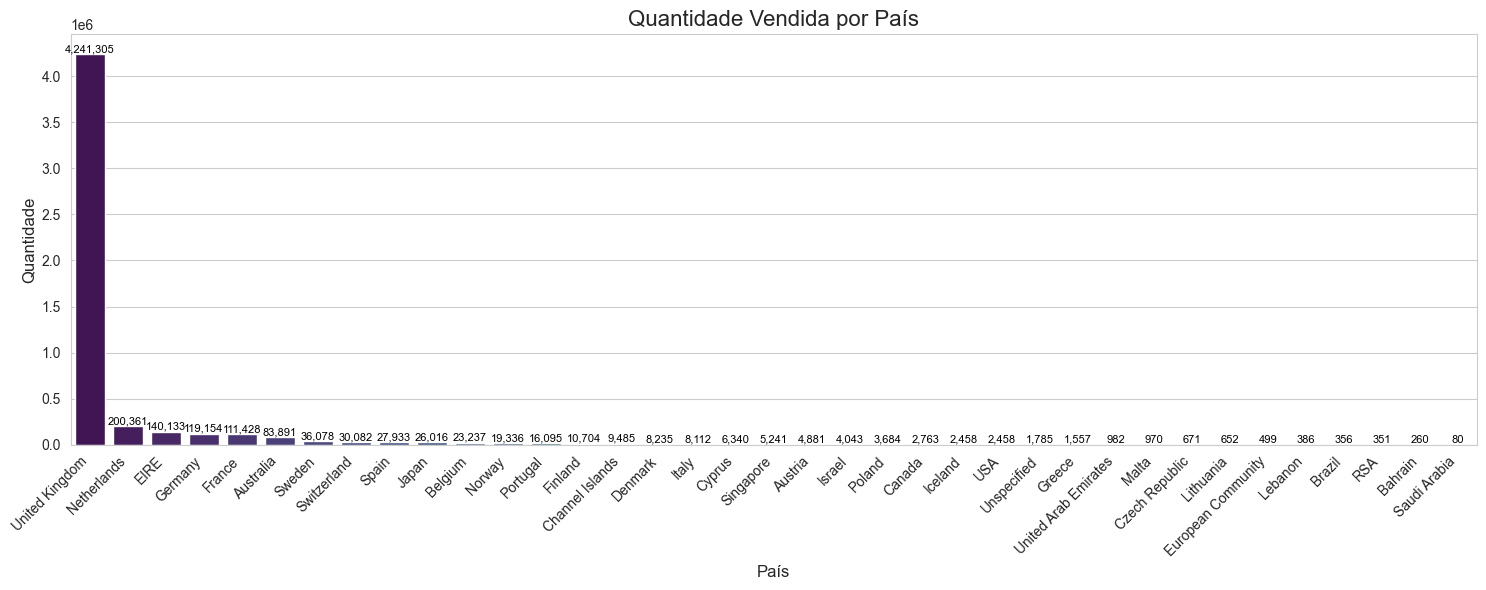

In [201]:
# Função para criação de gráficos futuros
def grafico_barra(df, agrupa, coluna_soma, titulo, xlabel, ylabel, operacao='sum', top_n=None):
    """
    Fução para criação rápida de um gráfico de barras.
    """
    if operacao == 'sum':
        df_agg = df.groupby(agrupa)[coluna_soma].sum().sort_values(ascending=False).reset_index()
    else:
        df_agg = df.groupby(agrupa)[coluna_soma].count().sort_values(ascending=False).reset_index()

    # Limita a quantidade de itens mostrados
    if top_n:
        df_agg = df_agg.head(top_n)

    # Define o estilo do gráfico
    sns.set_style('whitegrid')

    # Cria o gráfico
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(data=df_agg, x=agrupa, y=coluna_soma, palette='viridis')

    # Adiciona valores no topo das colunas
    for index, row in df_agg.iterrows():
        ax.text(index, row[coluna_soma], f'{row[coluna_soma]:,.0f}',
                color='black', ha='center', va='bottom', fontsize=8)


    # Adiciona título ao gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show();


# Analisando Vendas por Country (país)
grafico_barra(
    df=df,
    agrupa='Country',
    coluna_soma='Quantity',
    titulo='Quantidade Vendida por País',
    xlabel='País',
    ylabel='Quantidade'
);

In [202]:
quantidade_diff_pais = df.groupby('Country').agg(
    Quantidade_vendas=('Quantity', 'sum')
).reset_index()

diff = quantidade_diff_pais.loc[quantidade_diff_pais['Country'] == 'United Kingdom']['Quantidade_vendas'].sum() / quantidade_diff_pais['Quantidade_vendas'].sum()  * 100
print(f'A maior parte das vendas vem do Reino Unido, representando {diff:.0f}% do total, tendo o maior peso na quantidade de vendas.\n'
      'Dentre os 5 maiores paises, todos ficam no continente europeu.')

A maior parte das vendas vem do Reino Unido, representando 82% do total, tendo o maior peso na quantidade de vendas.
Dentre os 5 maiores paises, todos ficam no continente europeu.


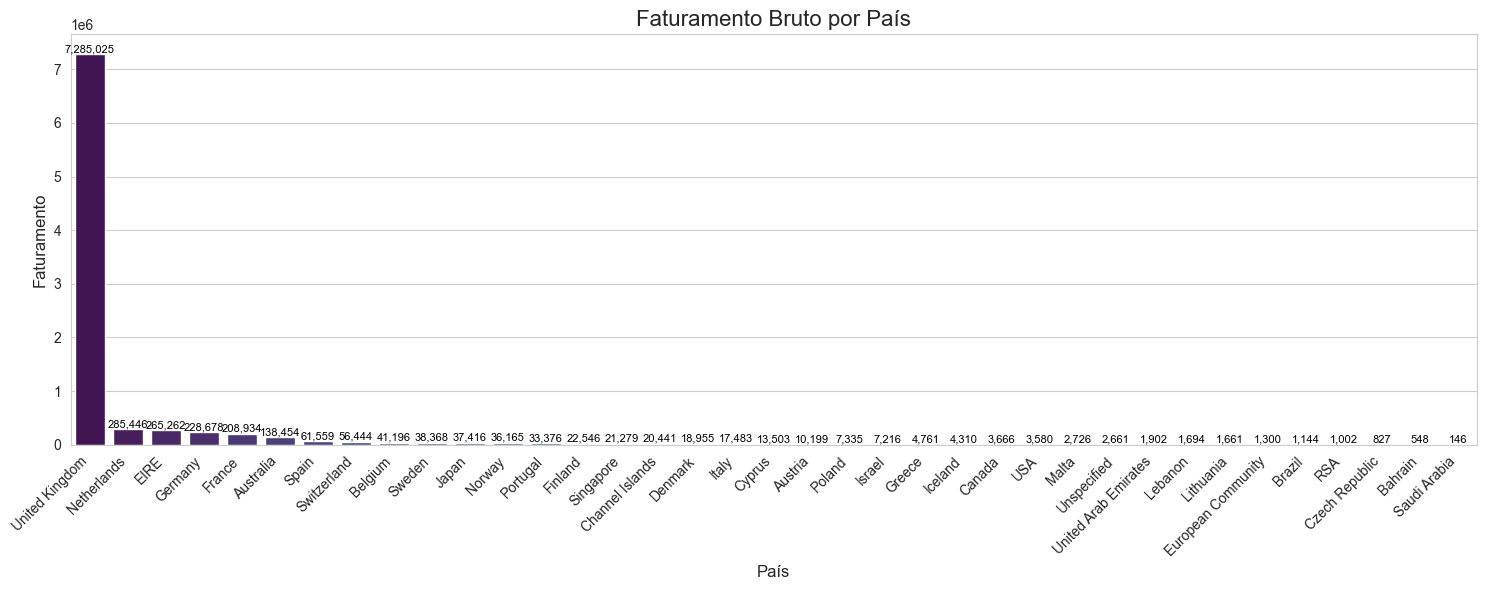

Em faturamento, vemos praticamente a mesma distribuição por quantidade.
O que nos indica, que a maior parte do faturamento, também está no Reino Unido


In [203]:
# Faturamento total de vendas por país.
grafico_barra(
    df=df,
    agrupa='Country',
    coluna_soma='TotalValue',
    titulo='Faturamento Bruto por País',
    xlabel='País',
    ylabel='Faturamento'
)

print('Em faturamento, vemos praticamente a mesma distribuição por quantidade.\n'
      'O que nos indica, que a maior parte do faturamento, também está no Reino Unido')

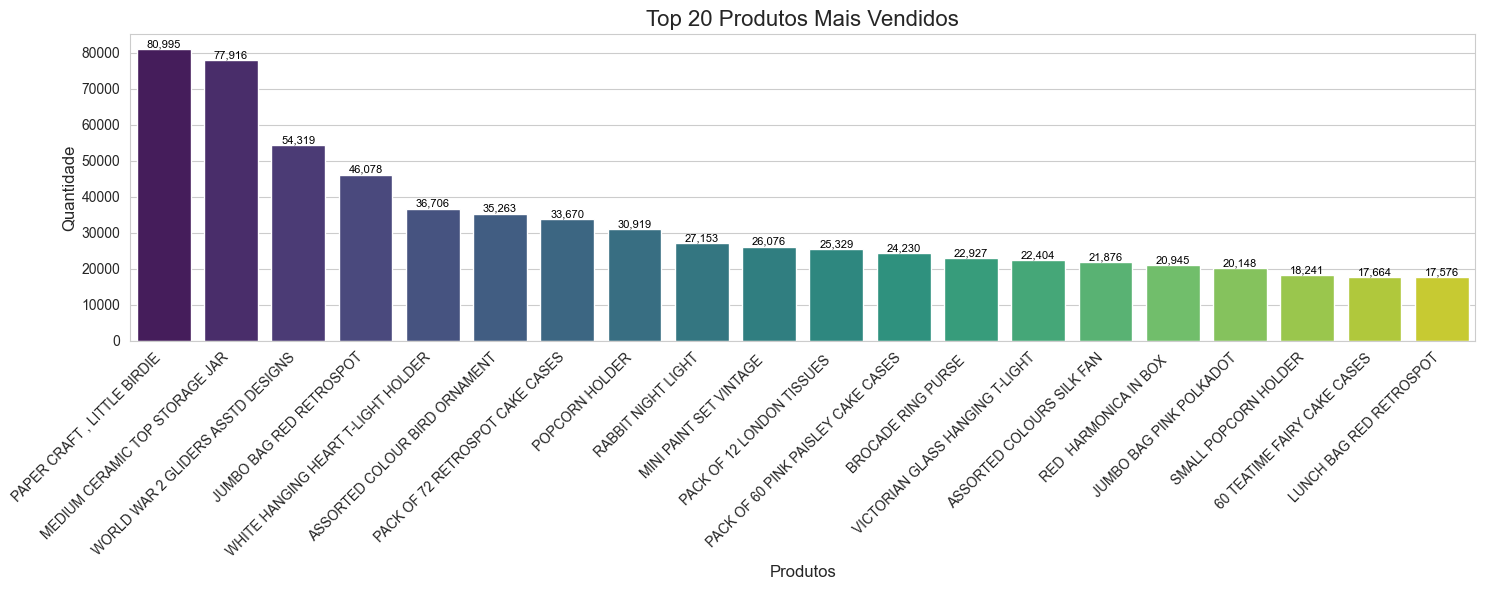

In [204]:
# Verificando os produtos mais vendidos
grafico_barra(
    df=df,
    agrupa='Description',
    coluna_soma='Quantity',
    titulo='Top 20 Produtos Mais Vendidos',
    xlabel='Produtos',
    ylabel='Quantidade',
    top_n=20
)

Dois produtos acabaram se destacando muito dentre os mais vendidos, estes são os produtos estrela.      
Uma sugestão, é sempre criar combos de vendas onde atrelamos os produtos menos vendidos aos estrela.

Vamos inserir novas colunas para complementar o estudo dos dados, em especial o RFM.       
1. R, Recência do pedido ou seja, a quantidade de dias desde o último dia do pedido.
2. F, Mede a frequência de pedidos do cliente.
3. M ou V, Valor gasto por cliente.

In [205]:
# Data de Referência
data_ref = pd.Timestamp('2011-12-09')

# Calculando RFM/V
df_rfm = df.groupby('CustomerID').agg(
    recencia = ('data', lambda x: (data_ref - x.max()).days),
    frequencia = ('CustomerID', 'count'),
    monetario = ('TotalValue', 'sum')
).reset_index()

df_rfm

,CustomerID,recencia,frequencia,monetario
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40
...,...,...,...,...
4333,18280.0,277,10,180.60
4334,18281.0,180,7,80.82
4335,18282.0,7,12,178.05
4336,18283.0,3,721,2045.53


# 2. Pré-Processamento dos dados

Vamos normalizar os dados, como visto abaixo, temos uma grande viriancia entre nossos dados numéricos

In [206]:
df[['Quantity', 'UnitPrice', 'TotalValue']].describe().round()

,Quantity,UnitPrice,TotalValue
count,392692.0,392692.0,392692.0
mean,13.0,3.0,23.0
std,180.0,22.0,311.0
min,1.0,0.0,0.0
25%,2.0,1.0,5.0
50%,6.0,2.0,12.0
75%,12.0,4.0,20.0
max,80995.0,8143.0,168470.0


Vamos utilizar a técnica de IQR (Intervalo entre quartis), que é uma técnica estatística para identificação de conjuntos outliers.

In [207]:
# Variáveis para normalização
cols = ['recencia', 'frequencia', 'monetario']
scaler = StandardScaler()
df_rfm[cols] = scaler.fit_transform(df_rfm[cols])

# Calculando Q1, Q3 e IQR para remoção de outliers
Q1 = df_rfm[['recencia', 'frequencia', 'monetario']].quantile(0.25)
Q3 = df_rfm[['recencia', 'frequencia', 'monetario']].quantile(0.75)
IQR = Q3 - Q1

# Removendo outliers com IQR
df_rfm_cleaned = df_rfm[~(
    (df_rfm[['recencia', 'frequencia', 'monetario']] < (Q1 - 1.5 * IQR)) |
    (df_rfm[['recencia', 'frequencia', 'monetario']] > (Q3 + 1.5 * IQR))
).any(axis=1)]

# Verificando o número de linhas antes e depois da remoção de outliers
print(f"Linhas antes da remoção de outliers: {df_rfm.shape[0]}")
print(f"Linhas após a remoção de outliers: {df_rfm_cleaned.shape[0]}")

Linhas antes da remoção de outliers: 4338
Linhas após a remoção de outliers: 3610


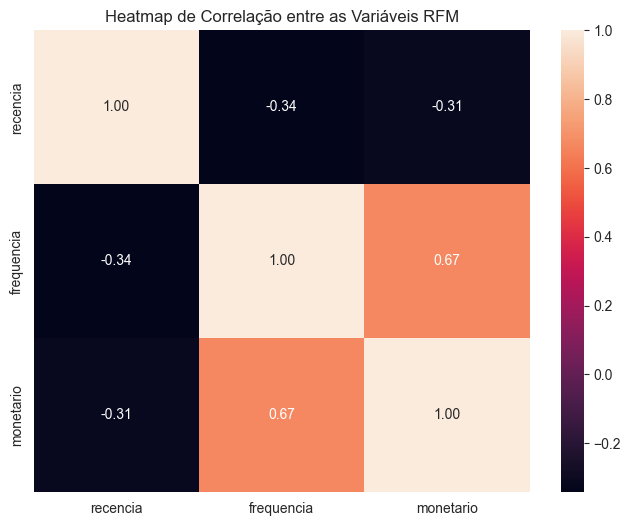

In [208]:
# Calculando a correlação
corr = df_rfm_cleaned[cols].corr()

# Plotando o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cbar=True)
plt.title("Heatmap de Correlação entre as Variáveis RFM")
plt.show()

Temos uma boa correlação da frequencia de compra com o valor gasto por cliente, ou seja clientes que compram com frequencia, tendem a ter um faturamento acumulado melhor.

### Método Elbow

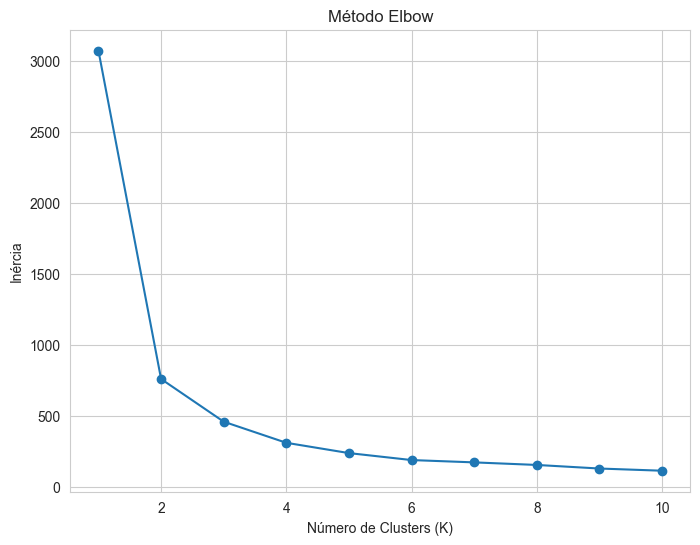

In [209]:
# Definindo a faixa de K para análise
k_range = range(1, 11)
inertia = []

# Calculando a inércia para diferentes valores de K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_cleaned[['recencia', 'frequencia', 'monetario']])
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do método Elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Método Elbow')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.show()

O 2º cluster, é claramente o de maior evidência.

### Método Silhouette Score

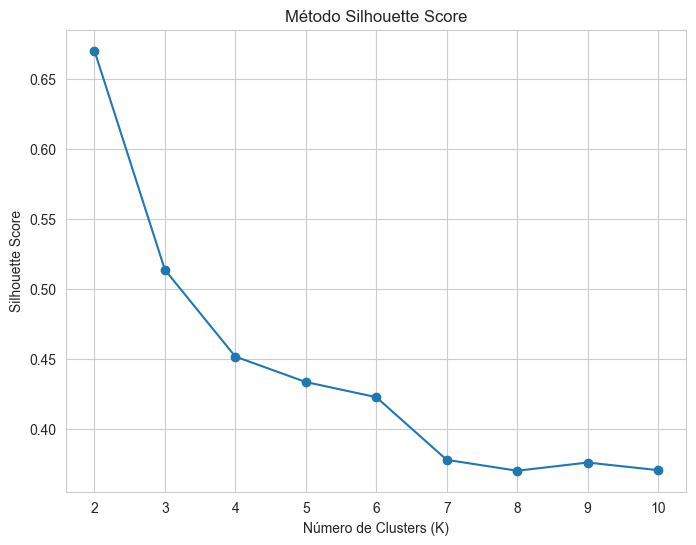

In [210]:
# Calculando o Silhouette Score para diferentes valores de K
sil_scores = []

for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_rfm_cleaned[['recencia', 'frequencia', 'monetario']])
    sil_scores.append(silhouette_score(df_rfm_cleaned[['recencia', 'frequencia', 'monetario']], cluster_labels))

# Plotando o gráfico do Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(k_range[1:], sil_scores, marker='o')
plt.title('Método Silhouette Score')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

Temos também o 2º cluster como o resultado, ambas as analises apontam para ele.

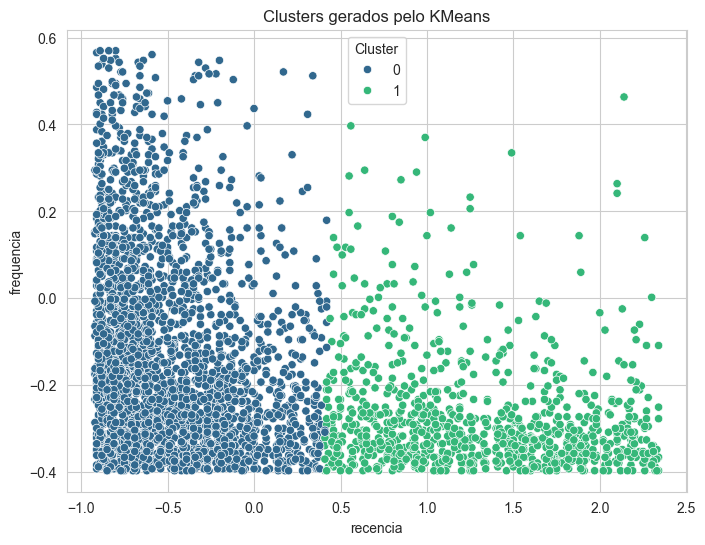

In [211]:
# Aplicando KMeans com o número ideal de clusters
kmeans = KMeans(n_clusters=2, random_state=42)
df_rfm_cleaned['Cluster'] = kmeans.fit_predict(df_rfm_cleaned[['recencia', 'frequencia', 'monetario']])

# Visualizando os clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='recencia', y='frequencia', hue='Cluster', data=df_rfm_cleaned, palette='viridis')
plt.title('Clusters gerados pelo KMeans')
plt.show()

### Interpretação dos clusters
Cluster 0 (esquerda, recência < 0.5):   

Este grupo parece representar clientes mais recentes, ou seja, clientes que realizaram compras mais recentemente.   
Pode ser útil para identificar clientes que estão no início de seu ciclo de vida e talvez precisem de ações para aumentar sua frequência ou valor monetário.    


Cluster 1 (direita, recência > 0.5):    

Este grupo provavelmente representa clientes que têm maior recência, ou seja, clientes que podem ser mais antigos ou que fizeram compras mais há pouco tempo, com um comportamento mais consolidado.    
Esses clientes podem ter maior potencial de valor monetário ou maior frequência de compras. 

# 3. Analisando Clusters obtidos

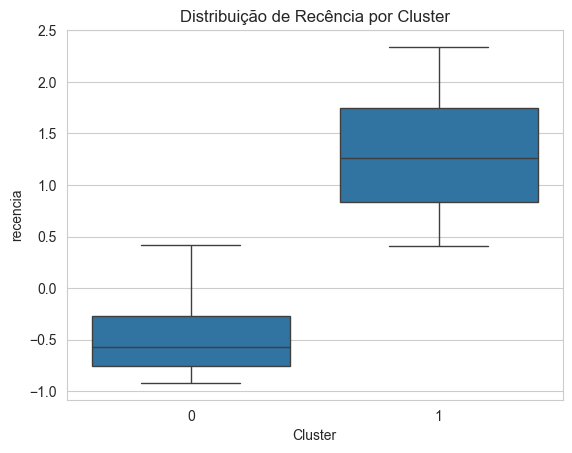

In [212]:
# Distribuição de recência
sns.boxplot(x='Cluster', y='recencia', data=df_rfm_cleaned)
plt.title('Distribuição de Recência por Cluster')
plt.show()

Temos uma clara diferença entre a recência dos clusters, clientes do cluster 1, compararam mais recentemente do que os do cluster 0.

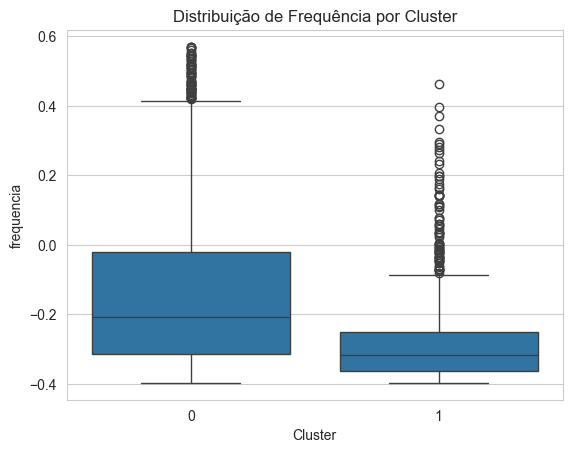

In [213]:
# Distribuição de Frequência
sns.boxplot(x='Cluster', y='frequencia', data=df_rfm_cleaned)
plt.title('Distribuição de Frequência por Cluster')
plt.show()

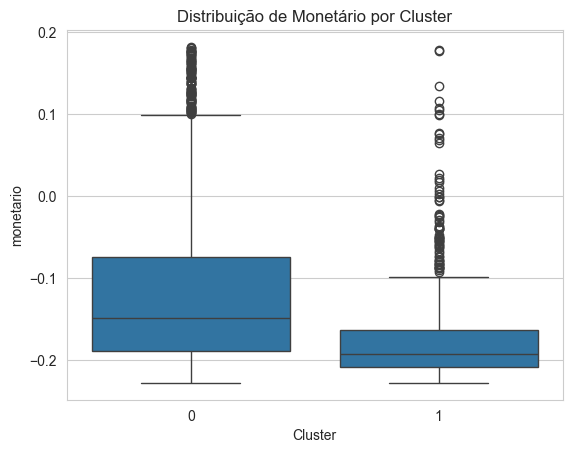

In [214]:
# Distribuição de Monetário
sns.boxplot(x='Cluster', y='monetario', data=df_rfm_cleaned)
plt.title('Distribuição de Monetário por Cluster')
plt.show()


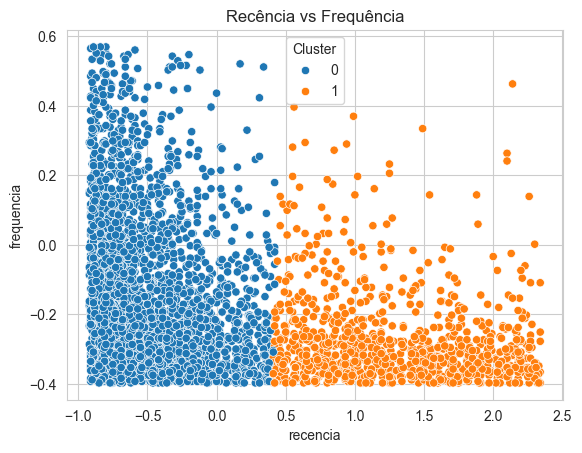

In [215]:
# Recência x Frequência
sns.scatterplot(x='recencia', y='frequencia', hue='Cluster', data=df_rfm_cleaned)
plt.title('Recência vs Frequência')
plt.show()


Temos uma clara representação onde clientes mais frequentes compram com menos recência.

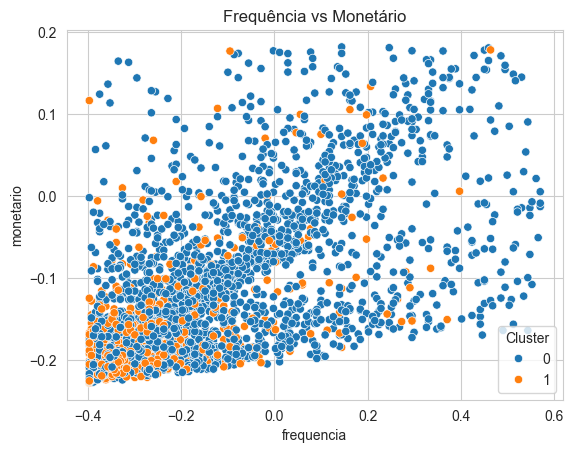

In [216]:
# Frequencia x Monetário
sns.scatterplot(x='frequencia', y='monetario', hue='Cluster', data=df_rfm_cleaned)
plt.title('Frequência vs Monetário')
plt.show()


Neste caso não temos relação entre a frequência dos clusters e o valor monetário gasto

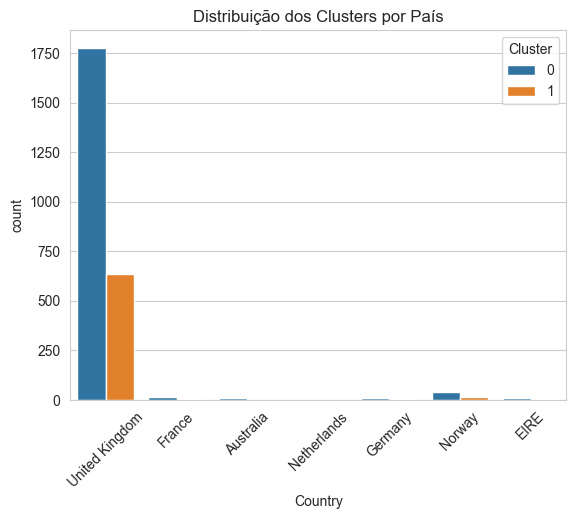

In [217]:
# Analisando frequência de compra por País
df_rfm_cleaned['Country'] = df['Country']
sns.countplot(x='Country', hue='Cluster', data=df_rfm_cleaned)
plt.title('Distribuição dos Clusters por País')
plt.xticks(rotation=45)
plt.show()

## 4. Análise dos Clusters Obtidos

### a. Diferenças Significativas entre os Clusters
- **Cluster 0**: A maioria dos países está concentrada no **Cluster 0**, o que indica que ele representa o grupo mais amplo de clientes. Esses clientes podem ter um comportamento de compra mais regular e consistente, com um perfil de consumo mais equilibrado. Para esse grupo, campanhas focadas em **manutenção e fidelização** seriam vantajosas.
- **Cluster 1**: A menor representação no **Cluster 1** sugere que esse grupo é mais restrito, com características mais específicas. Esses clientes podem ter um comportamento de compra mais esporádico. Estratégias de marketing para **reengajamento** seriam essenciais, como ofertas de **promoções especiais** ou campanhas **focadas em aumentar a frequência de compras**.

### b. Padrão de Distribuição entre os Países
- **Distribuição uniforme entre países**: O fato de **praticamente todos os países estarem concentrados no Cluster 0** sugere que a maioria dos clientes tende a ter comportamentos semelhantes em termos de recência, frequência e valor monetário. Isso pode indicar que campanhas de marketing devem ser **mais universais**, focadas em clientes com perfis mais tradicionais.
- **Investigar diferenças de mercado**: Se a distribuição é praticamente a mesma em todos os países, pode ser interessante investigar mais a fundo se existem outras variáveis não capturadas pelos dados que possam explicar esse comportamento.

### c. Frequência e Valor Monetário
- **Cluster 1** tem maior **recência**, **menor frequência** e **menor valor monetário**. Esses clientes podem estar em uma fase inicial do ciclo de vida como consumidores. Para esse grupo, estratégias de **reengajamento** podem ser necessárias para incentivar compras regulares.
    - Campanhas de **promoções de retenção** e **aumento da frequência de compras** seriam ideais.
    - Além disso, o **menor valor monetário** pode indicar que esses clientes fazem compras de menor valor. Estratégias de **upselling** ou **cross-selling** podem ser eficazes para aumentar o ticket médio.
    
### d. Otimização de Marketing e Personalização
- **Cluster 0**: Para os clientes predominantes no **Cluster 0**, pode-se focar em campanhas de **fidelização** para incentivar a continuidade das compras, com **descontos exclusivos** ou **promoções sazonais**. Esses clientes podem responder bem a ofertas que reforçam sua lealdade.
- **Cluster 1**: Para os clientes do **Cluster 1**, que têm um comportamento de compra mais esporádico, estratégias mais focadas em **incentivos de retorno**, como **cupons de desconto** ou **ofertas para compras em maior volume**, poderiam ser eficazes para aumentar a frequência de compras e o valor monetário gasto.

### e. Segmentação para Ações Regionais
- Embora a distribuição de clusters seja bastante uniforme, pode-se realizar **estratégias mais centradas** em dados comportamentais e demográficos. Isso poderia envolver a criação de campanhas específicas para diferentes **países ou grupos etários**, considerando as particularidades de cada segmento de mercado.
  
### f. Outras Ações
- **Revisão de Preços**: Como o Cluster 1 tem um valor monetário baixo, pode-se investigar se a faixa de preço dos produtos está adequada. **Produtos com preços mais acessíveis** ou **promoções especiais** podem incentivar compras mais frequentes e aumentar o valor médio gasto.
- **Inovações em Produto ou Serviço**: Considerando que o Cluster 1 representa **novos consumidores**, pode ser interessante oferecer uma **experiência de compra mais interativa** ou personalizada para fidelizar esse público.
- **Análises Adicionais**: Uma análise mais profunda, incluindo variáveis como **comportamento sazonal** e **tipos de produto** comprados, pode trazer mais insights sobre como otimizar campanhas e ofertas.

---

Esses insights ajudam a **personalizar estratégias de marketing e vendas**, otimizando campanhas de acordo com os padrões de compra observados nos clusters.
